# Introduction to Bayesian Learning
## Mini-Project: Gaussian Mixtures using Variational Bayes and Metropolis-Hastings
**Student: VU Thi Hai Yen (haiyen96.hp@gmail.com)**

# 0. Install and collect packages

In [ ]:
# install.packages("MASS")
# install.packages("abind")
# install.packages("mnormt")
# install.packages("LaplacesDemon")
# install.packages("coda")

In [1]:
library(MASS)
library(abind)
library(mnormt)
library(LaplacesDemon)
library(coda)

# I. Simulation of GMM

In [2]:
N <- 500
p <- c(0.4, 0.3, 0.3)
Mu <- rbind(c(0,0),c(1,0),c(0,1))
set.seed(1)
Sigma <- rWishart(3, 4, 0.02*diag(2))
K = 3

In [3]:
n_gaussiens <- rmultinom(1, N, p)

In [4]:
X <- matrix(, nrow = 0, ncol = 2)
for (i in 1:K) {
    X <- rbind(X,mvrnorm(n_gaussiens[i], Mu[i,], Sigma[,,i]))
}

In [5]:
labs <- c()
for (i in 1:K) {
    labs <- c(labs,rep(i,n_gaussiens[i]))
}

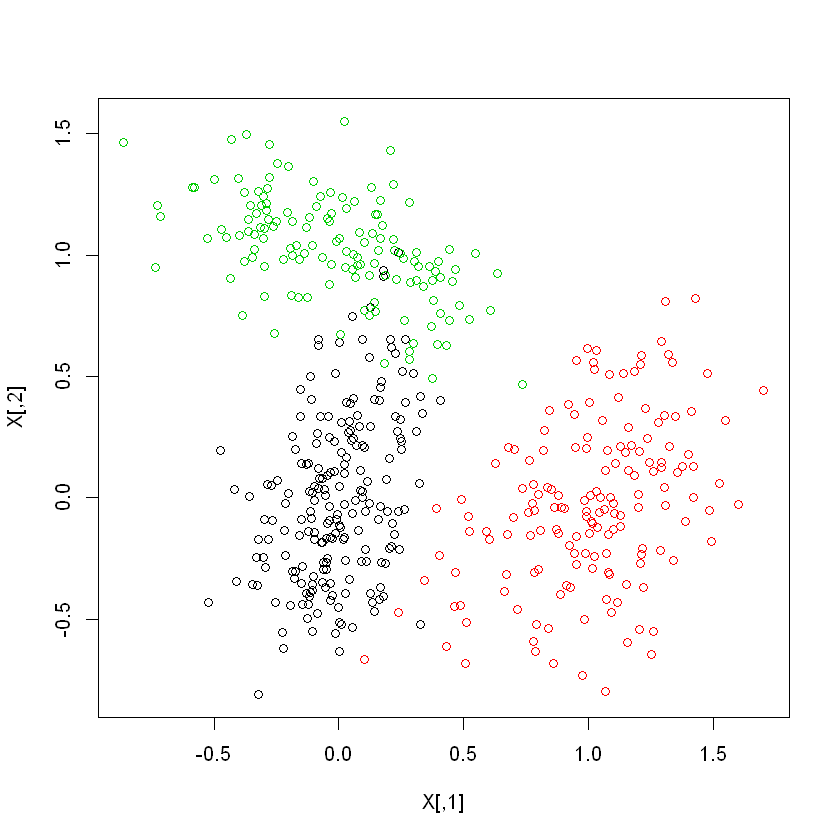

In [6]:
plot(X,col=labs)

We have generated our data set. Let's start with the Variational Bayes algorithms!

# II. Variational Bayes

In [7]:
#######################'
#' 1.  Common functions 
#######################' 

gmllk <- function(x , Mu , Sigma , p){
    #' Log-likelihood in the Gaussian mixture model. 
    #' x: dataset: a n*d matrix for n points with d features each.
    #' Mu: a k*d matrix with k the number of components: the centers
    #' Sigma: a d*d*k array:: the convariance matrices.
    #' p: a vector of length k: the mixture weights
    #' returns:  the log-likelihood (single number)
    k <- length(p)
    if(is.vector(x)){
        x <- matrix(x, nrow=1)}
    n <- nrow(x)
    mat_dens <- vapply(1:k, function(j){
        dmnorm(x, mean = Mu[j,], varcov = Sigma[,,j], log=FALSE)
    }, FUN.VALUE = numeric(n)) ##  n rows, k columns.
    if(is.vector(mat_dens)){
        mat_dens <- matrix(mat_dens, nrow = 1)
    }
    vect_dens <-   mat_dens%*%matrix(p,ncol=1) ## vector of size n
    return(sum(log(vect_dens)))
}


gmcdf <- function(x , Mu , Sigma , p)
    #' multivariate cumulative distribution function in a GMM. 
    #' x: a single point (vector of size d)
    #' Mu, Sigma, p: see gmllk.
    #' returns: the cdf at point x. 
{
    k <- length(p)
    vect_cdf <- vapply(1:k, function(j){
        pmnorm(x, mean = Mu[j,], varcov = Sigma[,,j])
    }, FUN.VALUE = numeric(1))
    return(sum(p*vect_cdf))
}


initPar <- function(x , k){
    #' Initialisation for VB based on kmeans. 
    #'x: dataset: a n*d matrix for n points with d features each.
    #'k: number of components for the inferred mixture
    #' returns: a list with entries p, Mu, Sigma: respectively a vector of size k (weights), a k*d matrix (centers) and a d*d*k array (empirical covariance matrix)
    init <- kmeans(x = x, centers = k, iter.max = 100, nstart = 1,
                   algorithm = c("Hartigan-Wong"), trace=FALSE)
    Mu <- init$centers
    d <- ncol(x)
    Sigma <- array(dim=c(d,d,k))
    p <- rep(0,k)
    for( i in (1:k)){
        inds = which(init$cluster==i)
        n = length(inds)
        tildeX = t(t(x[inds,]) -Mu[i,])  
        sig = 1/n * t(tildeX) %*% tildeX
        Sigma[,,i] <- sig
        p[i] <-  n/nrow(x)
    }
    return(list(p = p, Mu = Mu, Sigma = Sigma ))
}


draw_sd <- function(mu , sigma)
    #' draws  an ellipsoid  around the mean of a gaussian distribution
    #' which corresponds to the density level set of the univariate
    #' 0.95 quantile.
    #' mu: vector of size d the dimension
    #' sigma: a d*d covariance matrix.
    #' returns: a 2*100 matrix containing abscissas and ordinates of
    #' the ellipsoid to be drawn. 
{
    L <-  chol(sigma)
    angles <- seq(0, 2*pi, length.out=100)
    U <- 1.64* rbind(cos(angles), sin(angles))
    X <- mu + t(L) %*% U
    return(X)
}

nanDetector <- function(X)
    #' returns TRUE if X contains NaNs
{
   # examine data frames
   if(is.data.frame(X)){ 
       return(any(unlist(sapply(X, is.nan))))
   }
   #  examine vectors, matrices, or arrays
   if(is.numeric(X)){
       return(any(is.nan(X)))
   }
   #  examine lists, including nested lists
   if(is.list(X)){
       return(any(rapply(X, is.nan)))
   }
   return(FALSE)
}

wrapper <- function(x , y , FUN, ...)
    #' applies a function on a grid with abscissas x, y.
    #' x, y: vectors of same length.
      {
       sapply(seq_along(x), FUN = function(i){FUN(x[i], y[i],...)})
      }

## II.1. Functions vbMStep, vbEstep, vbalgo

In [8]:
################################'
##' 2. Variational Bayes functions 
################################' 

vbMstep <- function(x , respons , alpha0 ,  W0inv , nu0 , m0 , beta0)
    #' x: the data. A n*d matrix 
    #' respons: current q(z): a n*k matrix (responsibilities r_{nk})
    #' alpha0>0: a real.  isotropic dirichlet prior parameter on p
    #' W0inv, nu0: parameters for the Wishart prior on Lambda.
    #' W0inv: d*d matrix, inverse of the Wishart parameter.
    #' nu0 > d-1:  is a real.
    #' m0 : mean parameter (d vector) for the Gaussian-Wishart prior on  mu
    #' beta0: scale parameter for the gaussian-wishart  prior on mu (>0)
    ##' 
    #' returns: a list made of ( Alpha , Winv, Nu , M , Beta):  optimal parameters for
    #' q(p),
    #' q(mu_j, Lambda_j), j=1, ...,k: 
    #' Alpha: k-vector ; Winv: d*d*k array ; Nu: a k-vector ; M: k*d matrix ;
    #' Beta: k-vector                   
{
    K <-  ncol(respons)
    d <- ncol(x)
    
    NK <- apply(respons, 2, sum) # a vector of size k
    NK <- sapply(NK, function(x){max(x, 1e-300)}) ## avoids divisions by zero
    
    ## complete the code (optimal Alpha): vector of size k
    Alpha <- alpha0 + NK

    ## complete the code (optimal nu): vector of size k
    Nu <- nu0 + NK 
    
    ## complete the code (optimal Beta): vector of size k
    Beta <- beta0 + NK

    ## complete the code: optimal mean parameters m_j for the mu_j's: a k*d matrix
    XbarK <- 1/NK*(t(respons)%*%x) # compute x_bar_k: k*d matrix
    M <- array(dim=c(K,d))
    for (j in (1:K)){
       M[j,] <- 1/Beta[j]*(beta0*m0 + NK[j]*XbarK[j,])
    }
        
    
    Winv <- array(dim=c(d,d,K))
    for( j in (1:K)){
        ## compute NkSk: d*d matrix
        NkSk <- matrix(respons[,j] %*% t(apply(t(apply(x,1, function(y){y-XbarK[j,]})), 1, function(y) {y %*% t(y)})),d)
        ## complete the code: optimal W^{-1}
        Winv[,,j] <- W0inv + NkSk + (beta0*NK[j])/(beta0+NK[j])*((XbarK[j,]-m0) %*% t(XbarK[j,]-m0))
            ##(inverse of the covariance parameter for Lambda_j)
            ## a d*d matrix
    }

    return(list(Alpha = Alpha, Winv = Winv, Nu = Nu, M= M, Beta =Beta)) 
}


vbEstep <- function(x, Alpha, Winv, Nu, M, Beta)
    #' computation of the variational responsibilities. 
    #' x: the data. A n*d matrix
    #' Alpha: a k vector: current dirichlet parameter for q(p)
    #' Winv : a d*d*k array: current inverses of the W parameter for the Wishart q(Lambda)
    #' Nu: a k vector: current degrees of freedom parameter for the Wishart q(Lambda)
    #' M: a k*d matrix: current mean parameters for the Gaussian q(Mu | Lambda)
    #' Beta: a k vector: current scale parameters for the Gaussian q(Mu | Lambda)
    #' returns: a n*k matrix: the responsibilities for each data point.  
{
    d <-  ncol(M)
    k <- length(Alpha)
    N <- nrow(x)
    Eloglambda <-  # k vector
        sapply(1:k, function(j){
            sum(digamma( (Nu[j] + 1 - (1:d) )/2) )+ d * log(2) - log(det(Winv[,,j]))
        })
    Elogrho <- # k vector
        digamma(Alpha) - digamma(sum(Alpha))    
    Equadratic <- # k*N  matrix
         d / Beta  + Nu * t( sapply(1:k, function(j){ ## a N * k matrix
            Wj <- solve(Winv[,,j])
            sapply(1:N, function(n){# a N vector
                t(M[j,] -x[n, ]) %*% Wj %*% (M[j,] -x[n, ])})
        }))
    logResponsT <- ## Complete the code: the transpose of
        ## the unnormalized log-responsibility matrix, ie. a k * N matrix
        apply(- 1/2*Equadratic, 2, function(y){y + Elogrho + 1/2*Eloglambda}) 
    logRespons <- t(logResponsT) ## N * k
    logRespons <- logRespons - apply(logRespons, 1, max) #' avoids numerical precision loss. 
    respons <- exp(logRespons) ##  N * k matrix
    Z <-  apply(respons, 1 , sum ) # N vector
    respons <-  respons / Z ##N * k matrix
    return(respons)
}

vbalgo <- function(x, k, alpha0,  W0inv, nu0, m0, beta0, tol=1e-5)
    #' x: the data. n*d matrix
    #' k: the number of mixture components. 
    #' alpha0, W0inv, nu0, m0, beta0: prior hyper-parameters, see vbMstep.
    #' returns: a list composed of (Alphamat,  Winvarray, Numat, Marray, Betamat, responsarray, stopCriteria):
    #'   optimal parameters for q(p), q(mu_j, Lambda_j), j=1, ...,k, and trace of the
    ## stopping criteria along the iteration. 
    #'   Alphamat: K* Tmatrix,  Winvarray: d*d*T array,  Numat: a k*T matrix-vector, 
    #'   Marray: k*d*T array,  Betamat: k*T matrix, responsarray: n*k*T matrix, 
    #'   where T is the number of steps.
    #' stoppingCriteria: a T-vector:the stopping criterion  at each iteration (the first entry is set to the arbitrary 0 value)
{
    N <- nrow(x)
    d <- ncol(x)
    
    init <-  initPar(x=x,k=k)
    res <- list(Alphamat=matrix(nrow=k, ncol=0),
                Winvarray = array(dim=c(d,d,k,0)),
                Numat = matrix(nrow=k, ncol=0),
                Marray= array(dim=c(k,d,0) ),
                Betamat = matrix(nrow=k, ncol=0),
                responsarray = array(dim=c(N,k, 0)),
                stopCriteria = c(0)
                )
    
    Winvstart <- array(dim=c(d,d,k))
    for(j in 1:k){
        Winvstart[,,j] <- init$p[j] * N *  init$Sigma[,,j]
        }
    current <- list( Alpha = N * init$p, 
                    Winv = Winvstart, 
                    Nu = N* init$p, 
                    M = init$Mu,
                    Beta = N * init$p)
    ## current: current list of hyper parameters for the variational distribution
    
    continue <- TRUE
    niter <- 0
    while(continue){        
        niter <- niter+1
        respons <- vbEstep(x=x, Alpha=current$Alpha, 
                           Winv=current$Winv, Nu=current$Nu, 
                           M=current$M, Beta=current$Beta) ## Complete the code
            
        if(nanDetector(respons)) {stop("NaNs detected!\n")}
        vbOpt <- vbMstep(x=x , respons=respons , 
                         alpha0=alpha0 ,  W0inv=W0inv , 
                         nu0=nu0 , m0=m0 , beta0=beta0)## Complete the code
            
        if(nanDetector(vbOpt)) {stop("NaNs detected!\n")}
        current <- vbOpt

        if(niter >=2){
            t <- ncol(res$Alphamat)
            # Complete the code for computing the stopping
                ## criterion at current iteration. 
            delta <- sqrt(
                sum((res$Alphamat[,t] - current$Alpha)^2) + sum((res$Betamat[,t] - current$Beta)^2)
              + sum((res$Numat[,t] - current$Nu)^2) + sum((res$Winvarray[,,,t] - current$Winv)^2) 
              + sum((res$Marray[,,t] - current$M)^2) + sum((res$responsarray[,,t] - respons)^2))
            
            res$stopCriteria <- c(res$stopCriteria,delta)
        }
        

        
        res$Alphamat <- cbind(res$Alphamat, current$Alpha)
        res$Winvarray <- abind(res$Winvarray, current$Winv,along=4)
        res$Numat <- cbind(res$Numat, current$Nu)
        res$Marray <- abind(res$Marray, current$M,along=3)
        res$Betamat <- cbind(res$Betamat, current$Beta)
        res$responsarray <- abind(res$responsarray, respons,along=3)
        
            if(niter>=2){
                if( niter == 200  ||  delta < tol)              
            {continue <- FALSE}
        }
    }
        return(res)
        
}

## II.2. Test the VB algorithm

We start running the algorithm, we set here Kfit = 4.

[1] 147.7480 195.5482 157.0038   0.1000

-1.299215e-02,1.012430e+00
-2.721257e-03,-4.138295e-02
1.025369e+00,-1.638918e-02
2.722955e-10,-2.620707e-10


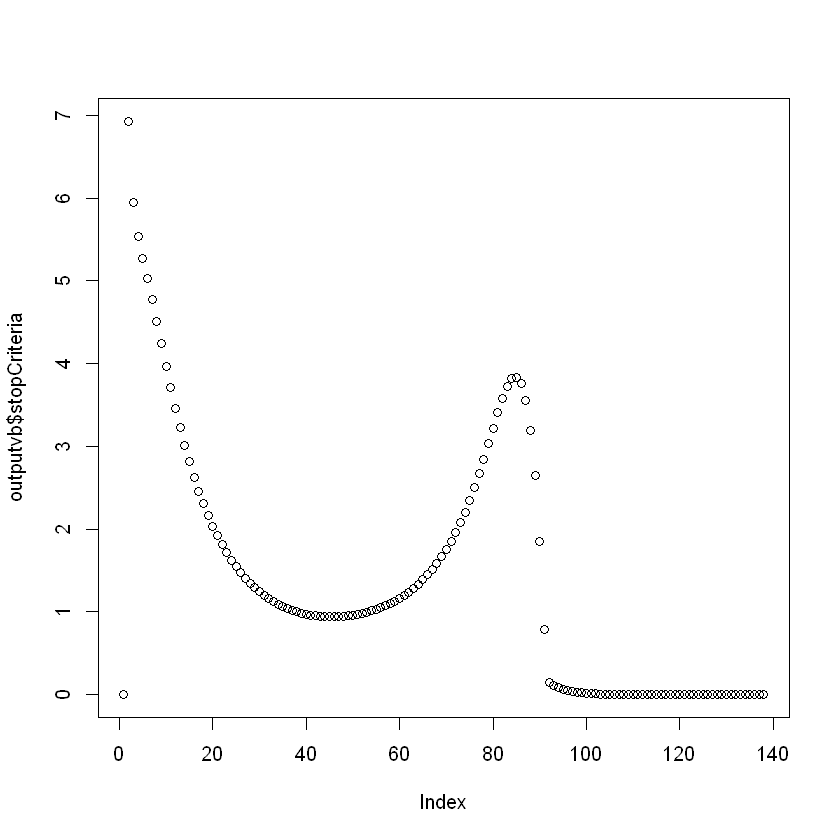

In [9]:
#########################'
#' 2. VB
#########################' 
#' Bayesian model: 
#' p ~ dirichlet(alpha);  alpha = (alpha0, ... , alpha0)
#' [ xi | p ] ~ Multinomial(p)
#' [ mu_j | Lambda_j ] ~ Normal(m0, beta0 Lambda_j^(-1))
#' Lambda_j ~ Wishart(W0, nu0)
#' [ X| xi=j, mu, Lambda ] ~ Normal (mu_j, Lambda_j^(-1))


#' Bayesian model: 
#' p ~ dirichlet(alpha);  alpha = (alpha0, ... , alpha0)
#' [ xi | p ] ~ Multinomial(p)
#' [ mu_j | Lambda_j ] ~ Normal(m0, beta0 Lambda_j^(-1))
#' Lambda_j ~ Wishart(W0, nu0)
#' [ X| xi=j, mu, Lambda ] ~ Normal (mu_j, Lambda_j^(-1))

#' hyper-parameters : to be varied 
alpha0 <- 0.1
m0 <- rep(0,2)
beta0 <- 0.1
W0 <- 1*diag(2)
nu0 <- 10
#' Run VB 
#'
Kfit <- 4
seed <- 10
set.seed(seed)
outputvb <- vbalgo(x=X,k=Kfit, alpha0 = alpha0, W0inv = solve(W0),
                 nu0 = nu0, m0 = m0, beta0=beta0, tol=1e-6)

#' plot the Stopping criteria over iterations
plot(outputvb$stopCriteria)

#' show a summary of VB's output
T <- ncol(outputvb$Alphamat)
outputvb$Alphamat[,T]
outputvb$Marray[,,T] 

We see the algorithm succeeds to converge to a stationary solution after about 100 iterations. Among the 4 values in the vector Alpha, we see that there is a value nearly to zero. We also see that the last vector in the M matrix is also zero. This suggests that the algorithm manages to reduce to the true number of components in the model. Now we'll visualize the output of VB algorithm to confirm our predictions.

## II.3. Visualisation of VB's output

p_vb: 0.2952598 0.3907839 0.3137565 0.0001998401 
True p: 0.4 0.3 0.3 
Mu_vb:


-1.299215e-02,1.012430e+00
-2.721257e-03,-4.138295e-02
1.025369e+00,-1.638918e-02
2.722955e-10,-2.620707e-10


True Mu:


0,0
1,0
0,1


True Sigma:
, , 1

           [,1]       [,2]
[1,] 0.03323460 0.03280529
[2,] 0.03280529 0.14325716

, , 2

           [,1]       [,2]
[1,] 0.08203247 0.02990579
[2,] 0.02990579 0.11196628

, , 3

            [,1]        [,2]
[1,]  0.09152265 -0.03418465
[2,] -0.03418465  0.04148540

Sigma_vb:
, , 1

            [,1]        [,2]
[1,]  0.09668272 -0.03253666
[2,] -0.03253666  0.05272423

, , 2

           [,1]      [,2]
[1,] 0.03659756 0.0164993
[2,] 0.01649930 0.1004959

, , 3

           [,1]       [,2]
[1,] 0.07199524 0.03110598
[2,] 0.03110598 0.11407361

, , 4

              [,1]          [,2]
[1,]  1.000000e-01 -2.897214e-13
[2,] -2.897214e-13  1.000000e-01



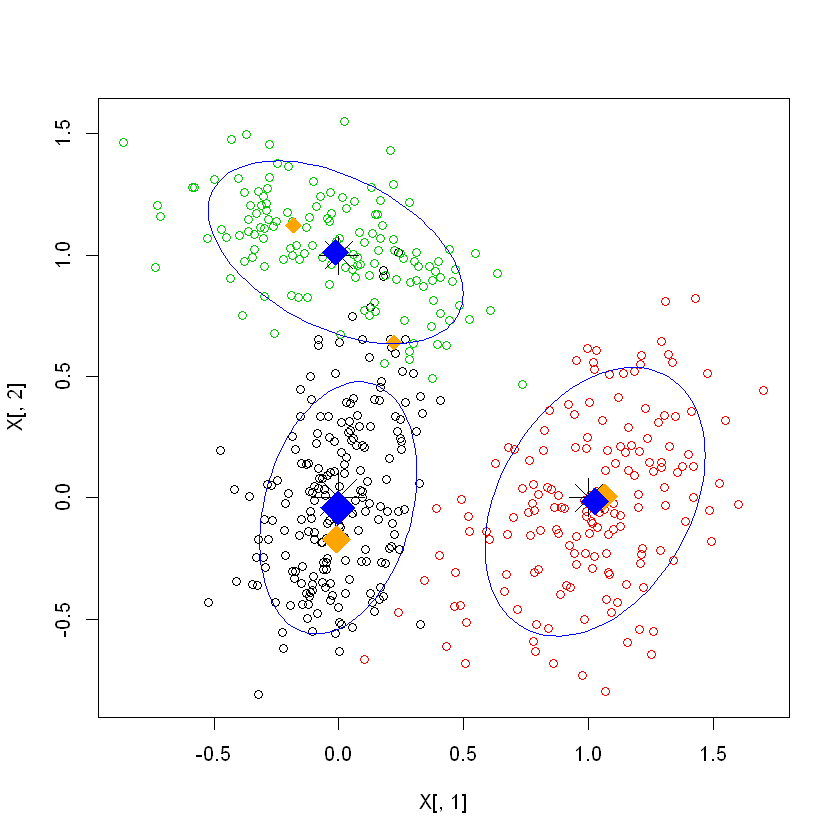

In [12]:
####################################################
#' Visual summary of VB's output :
####################################################
d = 2
T <- ncol(outputvb$Alphamat)
#' posterior expectancy of each parameter
## complete the code
p_vb <- outputvb$Alphamat[,T]/sum(outputvb$Alphamat[,T])

## complete the code
Mu_vb <- outputvb$Marray[,,T]

Sigma_vb <- array(dim=c(d,d,Kfit))
for(j in 1:Kfit){
    ## complete the code
    Sigma_vb[,,j] <- 1/outputvb$Numat[j,T]*outputvb$Winvarray[,,j,T]
}

cat("p_vb:",p_vb,"\n")
cat("True p:",p,"\n")
cat("Mu_vb:\n")
Mu_vb
cat("True Mu:\n")
Mu
cat("Sigma_vb:\n")
print(Sigma_vb)
cat("True Sigma:\n")
print(Sigma)

## show the data, true centers and initial positions from K-means
#graphics.off()
plot(X[,1], X[,2], col=labs)
points(Mu[,1],Mu[,2], col="black",pch=8,cex=10*p) 
set.seed(seed)
Init <-  initPar(X,Kfit)
points(Init$Mu[,1],Init$Mu[,2], col="orange",pch=18,cex = 10*Init$p)
## Add a  summary of the VB solution
nonneg <- which(p_vb>0.001)
for(j in nonneg){
    points(Mu_vb[j,1], Mu_vb[j,2], col="blue",
           pch=18,cex= 10 * p_vb[j])
    ellips <- draw_sd(mu = Mu_vb[j,], 
                      sigma = Sigma_vb[,,j])
    lines(ellips[1,], ellips[2,], col='blue')
}    

The algorithm fits beautifully the dataset. We see that it manages to recover the true number of components in the model. Considering the parameters, we see that the parameters obtained by the algorithm reach a level of precision of about $O(10^{-2})$.

## II.4. Influence of $\alpha_0$

We have seen in the previous questions that for $\alpha_0 = 0.1$, the algorithm succeeds to find the true number of components of GMM. Now we'll try other values of $\alpha_0$. We first define a function to run and visualize the VB algorithm.

In [31]:
runVBalgo <- function(x,k,alpha0,W0inv,nu0,m0,beta0,seed=10,tol=1e-6,print_values=F,plot_criteria=F,plot_VB=T) {
    set.seed(seed)
    outputvb <- vbalgo(x=x,k=k, alpha0 = alpha0, W0inv = solve(W0),
                 nu0 = nu0, m0 = m0, beta0=beta0, tol=tol)
    
    d <- ncol(x)
    T <- ncol(outputvb$Alphamat)
    p_vb <- outputvb$Alphamat[,T]/sum(outputvb$Alphamat[,T])
    Mu_vb <- outputvb$Marray[,,T]
    Sigma_vb <- array(dim=c(d,d,k))
    for(j in 1:k){
        Sigma_vb[,,j] <- 1/outputvb$Numat[j,T]*outputvb$Winvarray[,,j,T]
    }
    
    if (print_values) {
        cat("p_vb:",p_vb,"\n")
        cat("Mu_vb:\n")
        Mu_vb
        cat("Sigma_vb:\n")
        print(Sigma_vb)
    }
    
    if (plot_criteria) {
        plot(outputvb$stopCriteria)
    }
    
    if (plot_VB) {
        plot(x[,1], x[,2], col=labs)
        points(Mu[,1],Mu[,2], col="black",pch=8,cex=10*p)
        Init <-  initPar(X,Kfit)
        points(Init$Mu[,1],Init$Mu[,2], col="orange",pch=18,cex = 10*Init$p)
        ## Add a  summary of the VB solution
        nonneg <- which(p_vb>0.001)
        for(j in nonneg){
            points(Mu_vb[j,1], Mu_vb[j,2], col="blue",
                   pch=18,cex= 10 * p_vb[j])
            ellips <- draw_sd(mu = Mu_vb[j,], 
                              sigma = Sigma_vb[,,j])
            lines(ellips[1,], ellips[2,], col='blue')
            }
    }
    
    return(list(p_vb=p_vb,Mu_vb=Mu_vb,Sigma_vb=Sigma_vb))
}

We now set $\alpha_0 = 1$ and see the result.

-0.04206096,1.03902497
-0.01505126,-0.08130662
1.02654479,-0.01547336
0.19685162,0.58809856


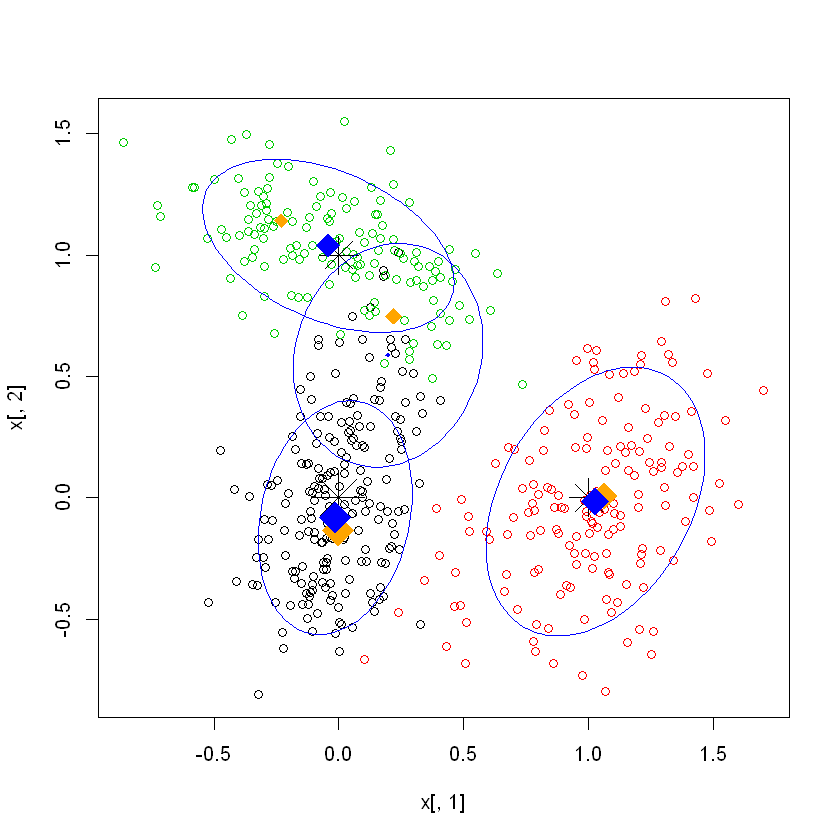

In [32]:
runVBalgo(x=X,k=Kfit, alpha0 = 1, W0inv = solve(W0),
                 nu0 = nu0, m0 = m0, beta0=beta0, tol=1e-6,
                  print_values=F,plot_criteria=F,plot_VB=T)

We see that as we increase $\alpha_0$, the model starts to find the other component more significant. However, its weight is still small compared to the 3 main components.

-0.04255615,1.044244699
-0.02174950,-0.227164388
1.03492871,-0.009235694
0.05830886,0.222947927


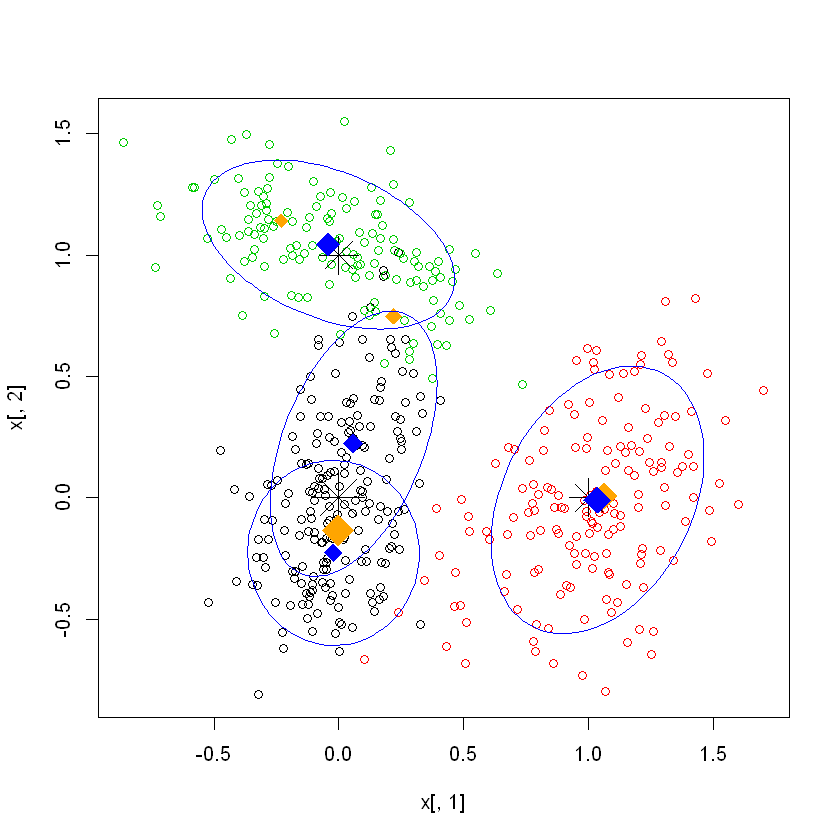

In [24]:
runVBalgo(x=X,k=Kfit, alpha0 = 10, W0inv = solve(W0),
                 nu0 = nu0, m0 = m0, beta0=beta0, tol=1e-6,
                  print_values=F,plot_criteria=F,plot_VB=T)

If we take $\alpha_0=10$, we see that the algorithm results in all component with significant weights.

## II.5. Influences of other hyper-parameters

We first increase $\beta_0 = 10$ and see the result.

9.233640e-03,8.508617e-01
-4.043861e-02,-1.117690e-01
9.001319e-01,-2.081824e-02
-7.143883e-09,-4.788315e-08


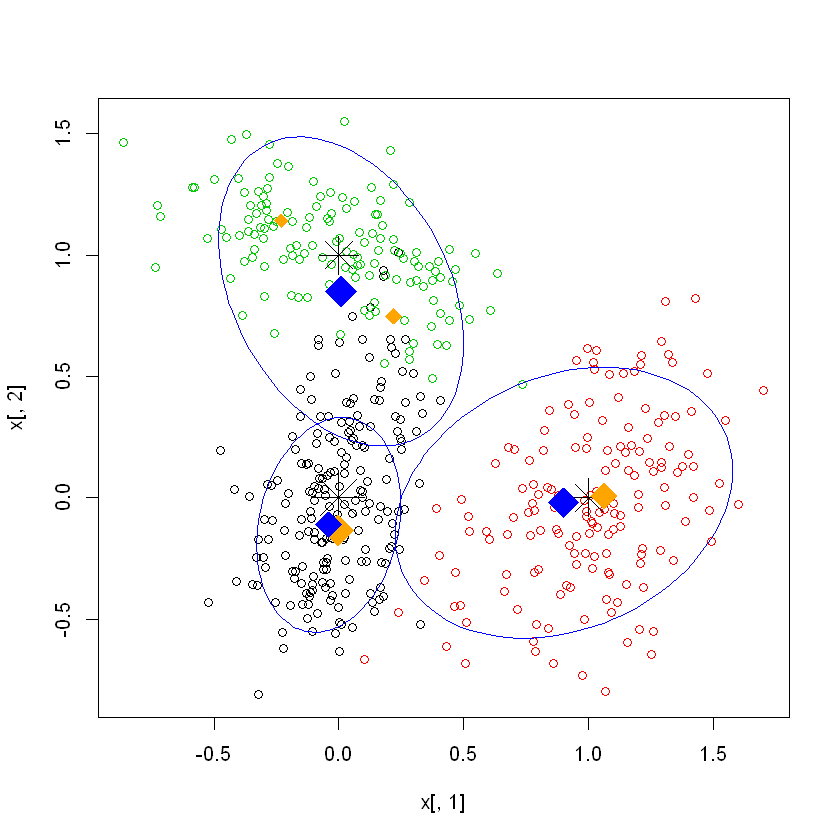

In [34]:
runVBalgo(x=X,k=Kfit, alpha0 = alpha0, W0inv = solve(W0),
                 nu0 = nu0, m0 = m0, beta0=10, tol=1e-6,
                  print_values=F,plot_criteria=F,plot_VB=T)

We see that the radius of the gaussian components tend to increase as $\beta_0$ increases, and they tend to comprise the data point from other components.

Now we change the value of $\nu_0$ to 100.

-0.186550326,1.12307931
-0.008591628,-0.04955267
1.025716128,-0.01514460
0.280284649,0.82840739


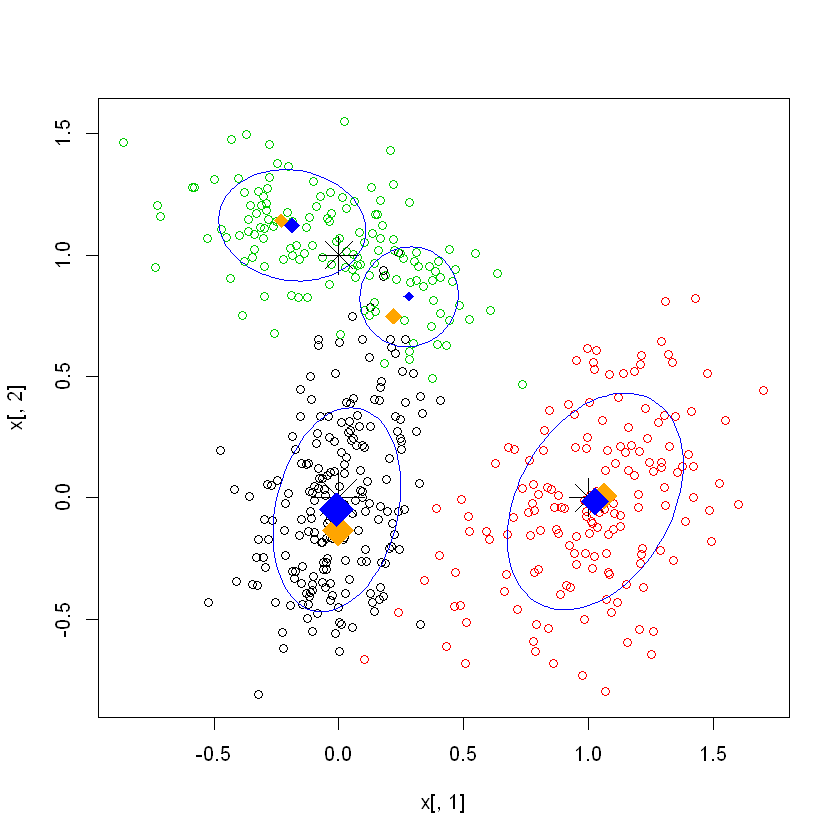

In [39]:
runVBalgo(x=X,k=Kfit, alpha0 = alpha0, W0inv = solve(W0),
                 nu0 = 100, m0 = m0, beta0=beta0, tol=1e-6,
                  print_values=F,plot_criteria=F,plot_VB=T)

We again see that the algorithm fails to recover the true number of components.

Now, let $m_0=c(10,10)$.

-0.11497913,1.09116728
0.05304608,0.11104408
1.01786498,-0.01982138
10.00000000,10.00000000


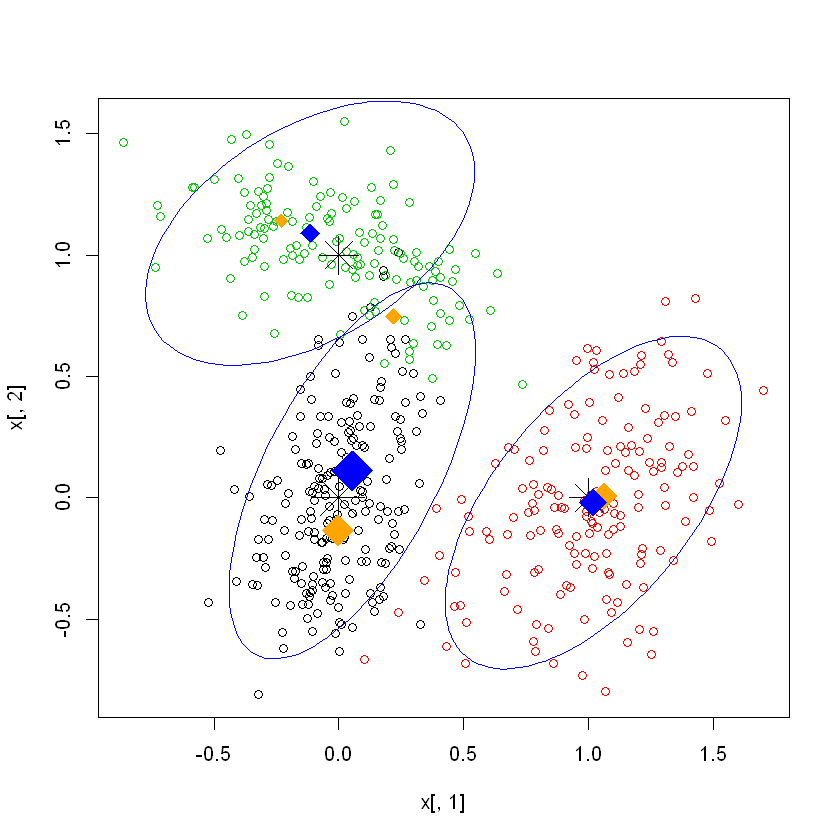

In [49]:
runVBalgo(x=X,k=Kfit, alpha0 = alpha0, W0inv = W0inv,
                 nu0 = nu0, m0 = 10+m0, beta0=beta0, tol=1e-6,
                  print_values=F,plot_criteria=F,plot_VB=T)

We already see that the algorithm start to deviate from the true parameters of the model. We can see this more clearly if we increase even more $m_0$.

100.0000000,100.0000000
0.3370029,0.2977784
100.0000000,100.0000000
100.0000000,100.0000000


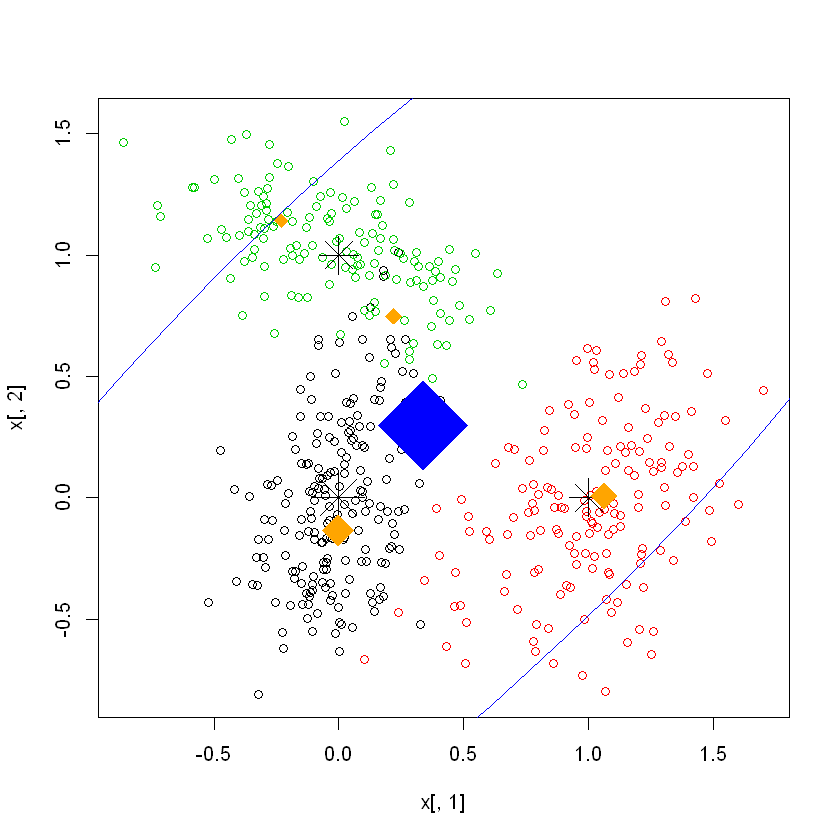

In [51]:
runVBalgo(x=X,k=Kfit, alpha0 = alpha0, W0inv = W0inv,
                 nu0 = nu0, m0 = 100+m0, beta0=beta0, tol=1e-6,
                  print_values=F,plot_criteria=F,plot_VB=T)

The model reduce in one big component with very large variance.

We have further investigated $W_0$ but we have not seen anything significant about this hyperparameter.

# III. Metropolis-Hastings algorithm

In [56]:
##############################################'
###' 4. MCMC functions 
##############################################'

dprior <- function( Mu, Sigma, p,
                   hpar = list( alpha0= 1,
                               m0 = rep(0, ncol(Mu)), beta0 = 1, 
                               W0 = diag(ncol(Mu)), nu0 = ncol(Mu)))
    #'log-prior density on (Mu, Sigma, p)
    #' Mu, Sigma, p: see gmllk
    #' hpar: a list of hyper-parameters composed of
    #' - alpha0> 0 : isotropic dirichlet prior on p
    #' - m0: a d vector: mean parameter for the Gaussian-Wishart prior on Mu
    #' - beta0: a single number >0: scale parameter for the Gaussian-Wishart prior on Mu
    #' - W0: covariance parameter for the inverse-wishart distribution on Sigma
    #' - nu0: degrees of freedom >d-1 for the wishart distribution on Sigma.  
    
{
    d <- ncol(Mu)
    k <- length(p)
    prior_p <- ddirichlet(p, alpha= rep(hpar$alpha0, k), log = TRUE)
    prior_MuSigma <- sum(sapply(1:k, function(j){
        dnorminvwishart(mu = Mu[j,], mu0 = hpar$m0, lambda = hpar$beta0,
                        Sigma = Sigma[,,j], S = hpar$W0, nu = hpar$nu0,
                        log = TRUE)}))
    return(prior_p + prior_MuSigma)
}

## III.1. The rproposal function to simulate new parameters at each iteration

In [57]:
rproposal <- function( Mu, Sigma, p, ppar=list(var_Mu = 0.1,
                                               nu_Sigma = 10,
                                               alpha_p = 10))
    #' random generator according to a proposal kernel centered at the current value.
    #' Mu, Sigma, p: current mixture parameters, see gmllk.
    #' ppar: a list made of :
    #' - var_Mu: variance parameter for the gaussian kernel for Mu.
    #' - nu_Sigma: degrees of freedom for the Wihart kernel for Sigma
    #' - alpha_p: concentration aprameter for the Dirichlet kernel for p
    #' returns: a list fo proposal parameters: (Mu, Sigma, p), where 
    #'   p ~ dirichlet(Alpha) with mean = Alpha/sum(Alpha) = current p and
    #'   concentration parameter sum(Alpha) = alpha_p.
    #' Mu : a k*d matrix and Sigma: a d*d*k array: 
    #'   for j in 1:k,  Mu[j,]~ Normal(mean= current Mu[j,], covariance = var_Mu*Identity)
    #'   Sigma[,,j]~ Wishart(W = 1/nu_Sigma * current Sigma[,,j] ; nu = nu_Sigma)
    
{
    d <- ncol(Mu)
    k <- length(p)
    alphaProp <- sapply(ppar$alpha_p * p, function(x){max(x,1e-30)})
    ## this avoids numerical errors

    p <- rdirichlet(n=1, alpha = alphaProp)
    p <- sapply(p, function(x){max(x,1e-30)})
    p <- p/sum(p)
    for(j in (1:k))
    {
        ## complete the code. use function rmvn 
        Mu[j,] <- rmvn(n=1, mu=Mu[j,], Sigma=ppar$var_Mu*diag(d))
        ## complete the code. use function rwishart
        Sigma[,,j] <- rWishart(n=1, df=ppar$nu_Sigma, Sigma=1/ppar$nu_Sigma*Sigma[,,j])
    }
    return(list(Mu = Mu, Sigma = Sigma, p = p))
}

## III.2. The MHsample function that performs the MH algorithm

In [54]:
MHsample <- function(x, k, nsample,
                     init=list(Mu = matrix(0,ncol=ncol(x), nrow=k ),
                               Sigma = array(rep(diag(ncol(x)), k),
                                             dim=c(ncol(x), ncol(x), k)),
                               p = rep(1/k, k)),
                     hpar= list( alpha0= 1, 
                                m0 = rep(0, ncol(Mu)), beta0 = 1, 
                                W0 = diag(ncol(Mu)), nu0 = ncol(Mu)),
                     ppar = list(var_Mu = 0.1,
                                 nu_Sigma = 10,
                                 alpha_p = 10) )
    #' x: the data. A n*d matrix.
    #' k: the number of mixture components.
    #' nsample: number of MCMC iterations
    #' init: starting value for the the MCMC. Format: list(Mu, Sigma, p), see gmllk for details
    #' hpar: a list of hyper-parameter for the prior: see dprior.
    #' ppar: a list of parameter for the proposal: see rproposal.
    #' returns: a sample produced by the Metropolis-Hastings algorithm, together with
    #' the log-posterior density (unnormalized) across iterations, and number of acepted proposals.  as a list composed of
    #' - p: a k*nsample matrix
    #' - Mu: a k*d*nsample array
    #' - Sigma: a d*d*k*nsample array
    #' - lpostdens: the log posterior density (vector of size nsample)
    #' - naccept! number of accepted proposals. 
{
    d <- ncol(x)
    output <- list(p = matrix(nrow=k, ncol=nsample),
                   Mu = array(dim = c(k, d, nsample)),
                   Sigma = array(dim = c(d, d ,k, nsample)),
                   lpostdens = rep(0, nsample),
                   naccept = 0
                   )
    current <- init
    current$lpost <- gmllk(x=x, Mu=current$Mu,
                            Sigma = current$Sigma, p=current$p) +
        dprior(Mu = current$Mu, Sigma = current$Sigma, p = current$p,
               hpar = hpar)
    ## lpost: logarithm of the unnormalized posterior density.
    
    for (niter in 1:nsample){
        proposal <- rproposal(Mu = current$Mu, Sigma = current$Sigma, p=current$p,
                              ppar = ppar)

        proposal$lpost <- gmllk(x=x, Mu=proposal$Mu,
                                Sigma = proposal$Sigma, p=proposal$p) +
            dprior(Mu = proposal$Mu, Sigma = proposal$Sigma, p = proposal$p,
                   hpar = hpar)
    
            
        llkmoveSigma <- sum(vapply(1:k, FUN = function(j){
            dwishart(Omega =proposal$Sigma[,,j], nu=ppar$nu_Sigma,
                     S = 1/ppar$nu_Sigma * current$Sigma[,,j] , log=TRUE)},
            FUN.VALUE = numeric(1)))

        llkbackSigma <- sum(vapply(1:k, FUN = function(j){
            dwishart(Omega =current$Sigma[,,j], nu=ppar$nu_Sigma,
                     S = 1/ppar$nu_Sigma * proposal$Sigma[,,j] , log=TRUE)},
            FUN.VALUE = numeric(1)))
        alphaPropmove <- sapply(ppar$alpha_p * current$p, function(x){max(x,1e-30)})
        alphaPropback <- sapply(ppar$alpha_p * proposal$p, function(x){max(x,1e-30)})
        llkmovep <- ddirichlet(proposal$p, alphaPropmove, log = T)
        llkbackp <- ddirichlet(current$p, alphaPropback, log = T)
        lacceptratio <-  ## logarithm of the acceptance ratio.
            ## Complete the code using
            ## lproposal$lpost,  current$lpost,
            ## ddirichlet( ... , log=TRUE), llkbackSigma and llkmovesigma. 
            min(proposal$lpost - current$lpost + llkmovep + llkmoveSigma - llkbackp - llkbackSigma,0)

        U <- runif(1)
        if(U < exp(lacceptratio)){
        ##if (proposal$lpost > current$lpost) {
            current <- proposal
            output$naccept <- output$naccept + 1
        }
        output$p[,niter] <- current$p
        output$Mu[,,niter] <- current$Mu
        output$Sigma[,,,niter] <- current$Sigma
        output$lpostdens[niter] <- current$lpost            
    }
    return(output)
    
} 

## III.3. Testing the HM algorithm

We run the MH algorithm, this time we set Kmc=6.

In [103]:
####################################################'
####' Metropolis-Hastings
####################################################'
#' Basic testing for the MH sampler
#Kmc <- Kfit ## try with different values
Kmc <- 6
init <- initPar(x=X, k=Kmc)

hpar <- list( alpha0= alpha0, 
           m0 = rep(0, d), beta0 = beta0, 
           W0 = W0, nu0 = nu0)

ppar <- list(var_Mu = 0.001,
            nu_Sigma = 500,
            alpha_p = 500) 


set.seed(1)
pct <- proc.time()
outputmh <- MHsample(x=X, k=Kmc, nsample= 4000,
                    init=init, hpar=hpar, ppar=ppar)
newpct <- proc.time()
elapsed <- newpct - pct
elapsed
outputmh$naccept ## should not be ridiculously low. 

   user  system elapsed 
  24.69    0.00   24.74 

[1] 208

We see that the number of acceptances is about 150. Let's take a look at the log posterior history of the algorithm.

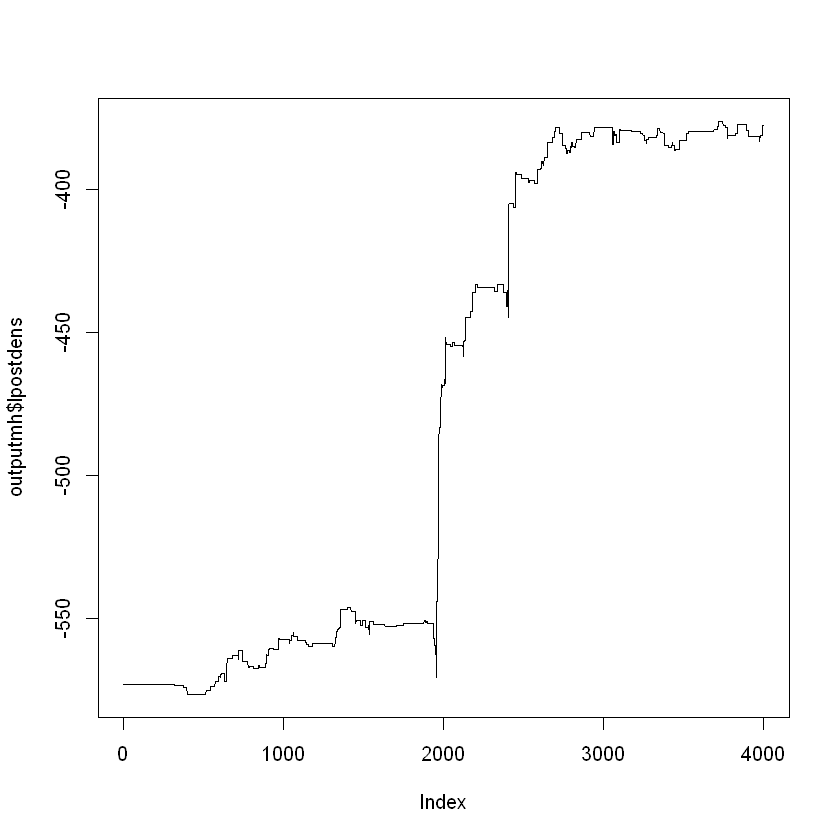

In [104]:
plot(outputmh$lpostdens, type="l", lwd=1)

We see that the log posterior generally increase, specially after 3000 samplings.

## III.4. The cdfTrace function
This function computes the trace of cumulative density function of a datapoint x during the sampling.

In [67]:
cdfTrace <- function(x , sample , burnin = 0 , thin = 1)
    #' Traces the evolution of the gmcdf at point x through the MCMC iterations.
    #'  Can be used for convergence monitoring. 
    #' x: a single point (vector of size d)
    #' burnin, thin: see MHpredictive
    #' returns: a vector of length [ (nsample - burnin )/thin ]
{
    nsample <- ncol(sample$p)
    inds <- (burnin+1):nsample
    inds <- inds[inds%%thin==0]
    output <- vapply(inds , function(niter){
        ## complete the code using gmcdf
        gmcdf(x=x,Mu=sample$Mu[,,niter],Sigma=sample$Sigma[,,,niter],p=sample$p[,niter])},
        FUN.VALUE = numeric(1))
    return(output)
}

## III.5 Convergence test using Heidelberger and Welch's test

We try with 2 random start values.

In [105]:
idx_list <- round(runif(5,1,N))

In [106]:
res_list <- lapply(idx_list, function(ind){ cdfTrace(x=X[ind,],sample=outputmh,burnin=0, thin = 1)})
res_list <- lapply(res_list, mcmc)
heidel.diag(mcmc.list(res_list))

[[1]]
                                   
     Stationarity start     p-value
     test         iteration        
var1 passed       1         0.0515 
                              
     Halfwidth Mean  Halfwidth
     test                     
var1 passed    0.333 0.00716  

[[2]]
                                   
     Stationarity start     p-value
     test         iteration        
var1 passed       1         0.152  
                              
     Halfwidth Mean  Halfwidth
     test                     
var1 passed    0.365 0.00709  

[[3]]
                                   
     Stationarity start     p-value
     test         iteration        
var1 passed       401       0.115  
                              
     Halfwidth Mean  Halfwidth
     test                     
var1 passed    0.243 0.00484  

[[4]]
                                   
     Stationarity start     p-value
     test         iteration        
var1 passed       1         0.0987 
                         

We see that all the chains passsed the test. However, different chains have different p-value, indicating that the stability is quite different. To better illustrate this, we'll plot the two chains.

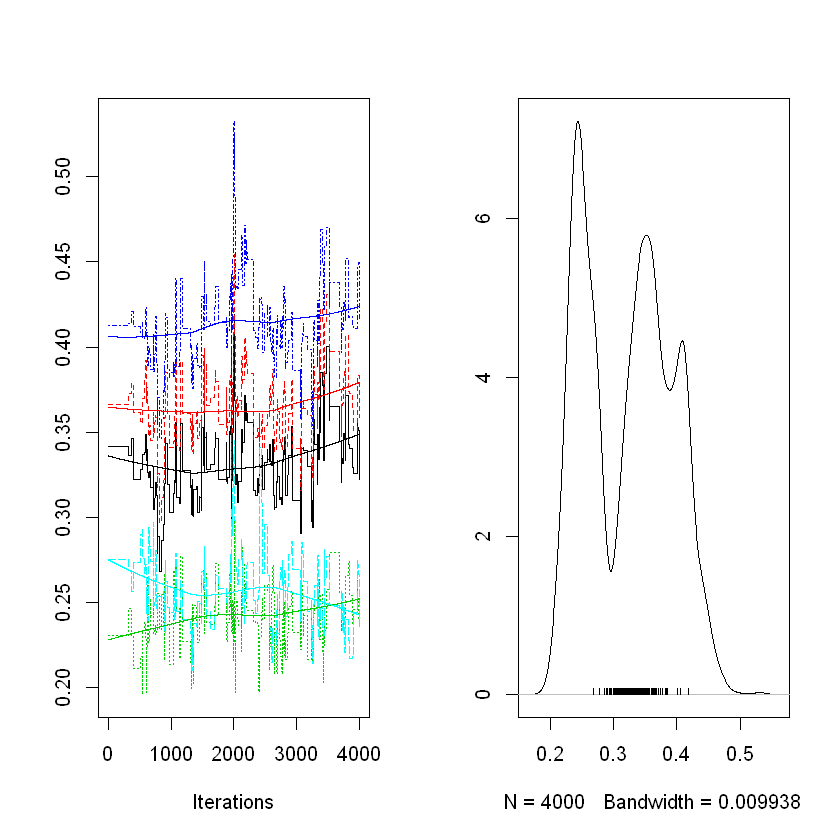

In [107]:
plot(mcmc.list(res_list))

We see that as p-value is quite low, we might need more iterations for this dataset.

## III.6. Convergence check with Gelman and Rubin's diagnostic

In this case we set the number of samplings to 5000. We run 3 different samplings.

In [108]:
outputmh1 <- MHsample(x=X, k=Kmc, nsample= 5000,
                    init=init, hpar=hpar, ppar=ppar)
outputmh2 <- MHsample(x=X, k=Kmc, nsample= 5000,
                    init=init, hpar=hpar, ppar=ppar)
outputmh3 <- MHsample(x=X, k=Kmc, nsample= 5000,
                    init=init, hpar=hpar, ppar=ppar)

In [110]:
ind <- round(runif(1,1,N))
result <- lapply(list(outputmh1,outputmh2,outputmh3), function(outmh){
    cdfTrace(x=X[ind,],sample=outmh,burnin=0, thin = 1)})
result <- lapply(result, mcmc)

Potential scale reduction factors:

     Point est. Upper C.I.
[1,]       4.37       7.21


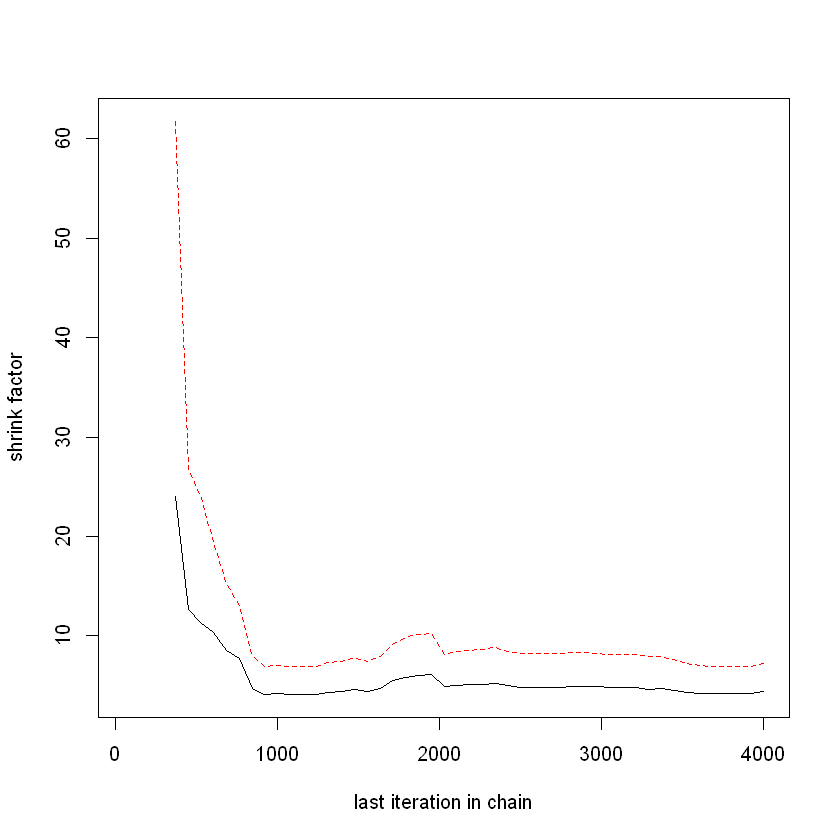

In [111]:
gelman.diag(mcmc.list(res_list))
gelman.plot(mcmc.list(res_list))

We see that wee can indeed burn from the 1000 index.

## III.7. Visualize the numerical approximation of density function

We first define the MHpredictive function as follows.

In [87]:
MHpredictive <- function(x , sample , burnin=0, thin=1)
    #' posterior predictive density computed from MH output. 
    #' x: vector size d (single point)
    #' sample: output from the MCMC algorithm should contain
    #'    entries Mu, Sigma, p as in MHsample's output
    #' burnin: length of the burn-in period
    #'   (number of sample being discarded at the beginning of the chain).
    #' thin: thinning parameter: only 1 sample out of 'thin' will be kept
    #' returns: a single numeric value
{
    nsample <- ncol(sample$p)
    inds <- (burnin+1):nsample
    inds <- inds[inds%%thin==0]
    vectllk <- vapply(inds, function(niter){
        ## complete the code
        exp(gmllk(x = x, sample$Mu[,,niter],Sigma=sample$Sigma[,,,niter],p=sample$p[,niter]))}
, FUN.VALUE = numeric(1)
  )
      return(mean(vectllk))
}

Let's draw the contours of density function.

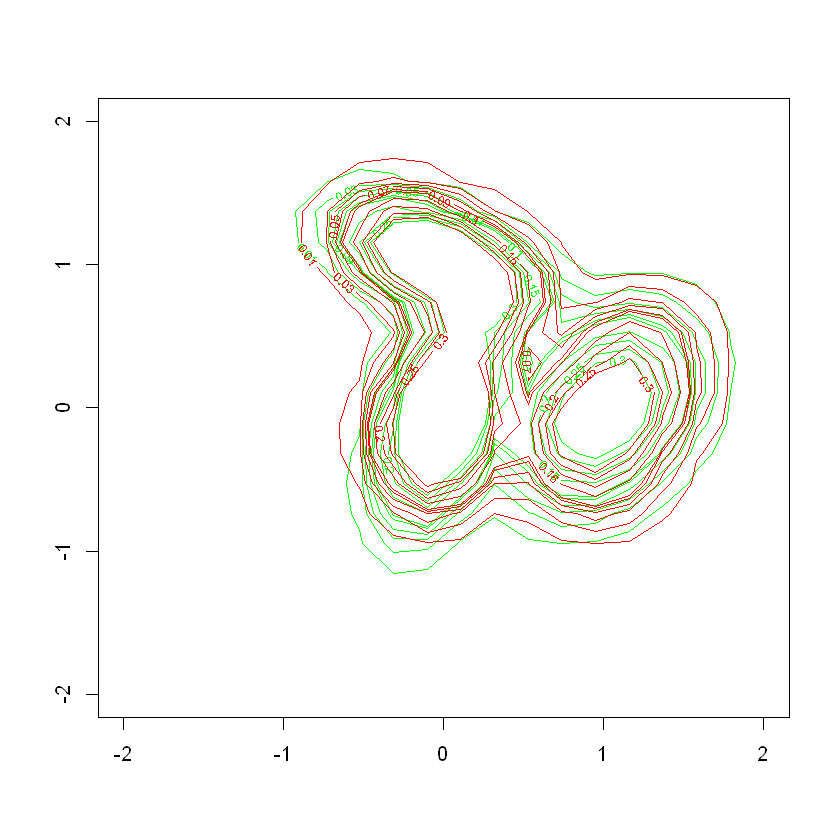

In [88]:
#######################################################
#' Predictive density
#' ####################################################
xx <- seq(-2,2,length.out=20)
yy <- xx
dtrue <- outer(X= xx, Y=yy,
            FUN = function(x,y){
                wrapper(x=x, y=y,
                        FUN=function(u,v){
                          exp(gmllk(x = c(u,v), Mu = Mu,
                          Sigma = Sigma, p = p))
                        })
            })

dpredmh <-  outer(X= xx, Y=yy,
            FUN = function(x,y){
                wrapper(x = x, y = y,
                        FUN =function(u,v){
                     ## complete the code    
                        MHpredictive(x = c(u,v) , sample = outputmh , burnin=0, thin=100)})
            })

breaks <- c(seq(0.01,0.09, length.out=5),seq(0.1,0.3,length.out=5))
nbreaks <- length(breaks)
contour(xx,yy, z = dtrue, nlevels=nbreaks, levels = breaks,col='green')
contour(xx,yy, z = dpredmh,  nlevels=nbreaks, levels = breaks,
          add=TRUE, col='red')

We see that the MH algorithm approximates very close to the true distribution.

# IV. Predictive distributions versus maximum likelihood distribution

## IV.1. The functions MHpredictiveCdf and vbPredictiveCdf

These two function compute the predictive cumulative density function of one single datapoint with respect to the outputs of MH and VB algorithms.

In [90]:
MHpredictiveCdf <- function(x , sample , burnin = 0, thin = 1)
    #' posterior predictive cdf computed from MH output.
    #' arguments: see MHpredictive.
    #' returns: a single numeric value. 
{
    nsample <- ncol(sample$p)
    inds <- (burnin+1):nsample
    inds <- inds[inds%%thin==0]

    vectcdf <- vapply(inds, function(niter){
    ## complete the code 
    gmcdf(x=x,Mu=sample$Mu[,,niter],Sigma=sample$Sigma[,,,niter],p=sample$p[,niter])
  }, FUN.VALUE = numeric(1)
  )
      return(mean(vectcdf))
}

In [91]:
vbPredictiveCdf <- function(x, Alpha, Beta, M, Winv, Nu)
    #' predictive cumulative distribution function based on the VB approximation.
    #' x: a single point (vector): where to evaluate the cdf. 
    #' Alpha, Winv, Nu, M, Beta: the VB posterior parameters,  see vbEstep
    #' returns the value of the variational posterior predictive cdf
    #'  (= mean of the mixture cdf under the variational posterior predictive)
    #'   at point x. 
{
    k <- length(Alpha)
    d <-  length(x)
    vectcdf <- vapply(X= 1:k, FUN= function(j){
        W <- Winv[,,j]
        L <-  (1 + Beta[j])/ ((Nu[j] + 1 - d) * Beta[j])  *   W
        L <- 1/2 * (L + t(L)) ## ensures symmetry despite numerical errors
        return(pmt(x=x, mean = M[j,], S = L, df = Nu[j] + 1 - d, log=FALSE))} ,
        FUN.VALUE= numeric(1) )

    return(sum(Alpha * vectcdf) / sum(Alpha))
}

## IV.2. Performance on a diagonal line

Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(d

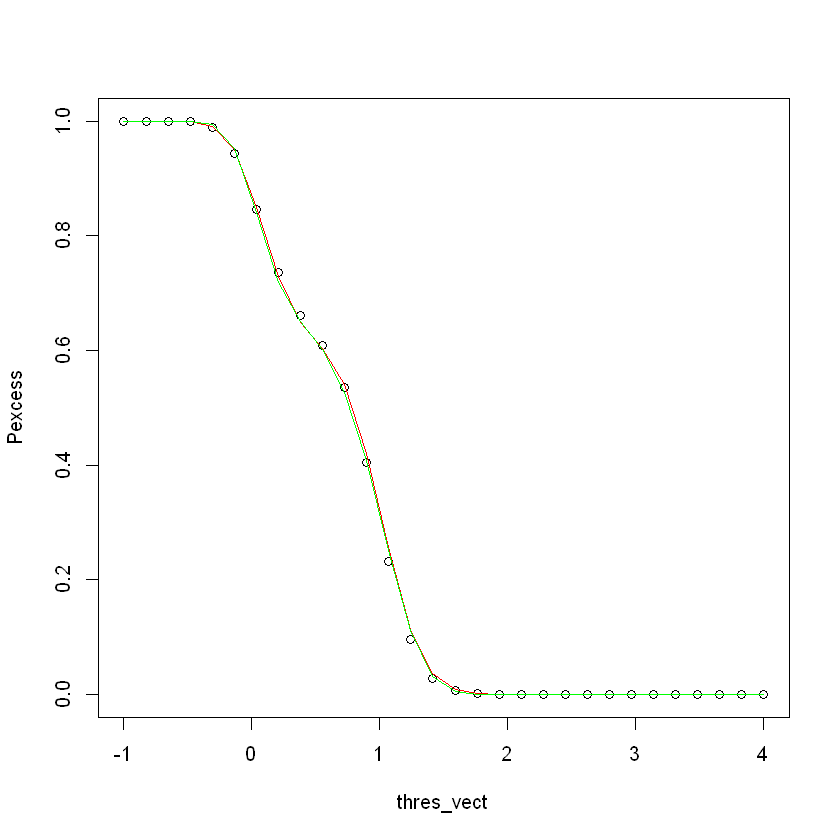

In [93]:
#########################'
##' predictive Cdf's
#########################'
Pexcess <- rep(0,10)
Pexcess_vb <- Pexcess; Pexcess_mh <- Pexcess
thres_vect <-  seq(-1, 4, length.out=30)
for(i in seq_along(thres_vect)){
threshold <- rep(thres_vect[i], 2)
Pexcess[i] <- 1 - gmcdf(x = threshold, Mu = Mu, Sigma=Sigma, p=p)
T <- ncol(outputvb$Alphamat)
Pexcess_vb[i] <-  ## complete the code:
    ## posterior predictive  estimator using VB output: 
    ## use vbPredictiveCdf
    1 - vbPredictiveCdf (x = threshold, 
                         Alpha = outputvb$Alphamat[,T], 
                         Beta = outputvb$Betamat[,T], 
                         M = outputvb$Marray[,,T], 
                         Winv = outputvb$Winvarray[,,,T], 
                         Nu = outputvb$Numat[,T])
    
Pexcess_mh[i] <-  ## complete the code:
    ## posterior predictive  estimator using MH output:
    ## use MHpredictiveCdf. 
    1 - MHpredictiveCdf(x = threshold , sample = outputmh , burnin = 0, thin = 100)
    }

ylim <- range(Pexcess, Pexcess_vb, Pexcess_mh)
plot(thres_vect,Pexcess, ylim = ylim)
lines(thres_vect, Pexcess_vb, col='red')
lines(thres_vect, Pexcess_mh, col='green')

We see that both the two methods approximate correctly the excess probability of the true model. We can see in this case that the VB algorithm stops at the two boundaries 0 and 1 while the HM algorithm manages to follow the true function.

## IV.3. Looking at the tail of the distribution

Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(df, lower = rep(-Inf, 2), upper = x[j, ], mean[j, :
"non integer df is rounded to integer"Warning message in biv.nt.prob(d

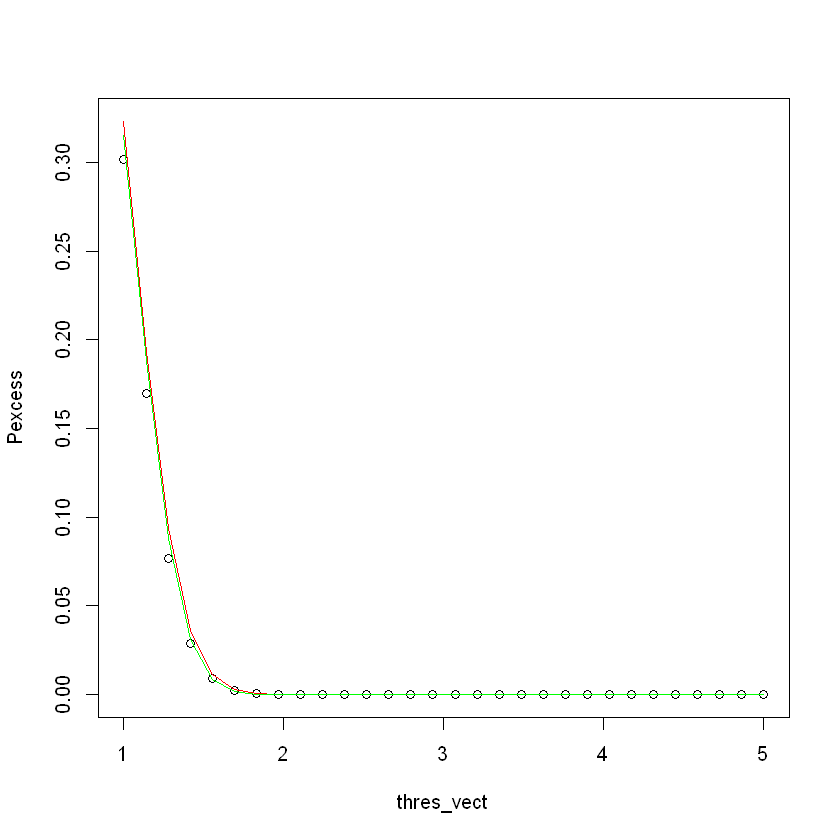

In [94]:
#########################'
##' predictive Cdf's
#########################'
Pexcess <- rep(0,10)
Pexcess_vb <- Pexcess; Pexcess_mh <- Pexcess
thres_vect <-  seq(1, 5, length.out=30)
for(i in seq_along(thres_vect)){
threshold <- rep(thres_vect[i], 2)
Pexcess[i] <- 1 - gmcdf(x = threshold, Mu = Mu, Sigma=Sigma, p=p)
T <- ncol(outputvb$Alphamat)
Pexcess_vb[i] <-  ## complete the code:
    ## posterior predictive  estimator using VB output: 
    ## use vbPredictiveCdf
    1 - vbPredictiveCdf (x = threshold, 
                         Alpha = outputvb$Alphamat[,T], 
                         Beta = outputvb$Betamat[,T], 
                         M = outputvb$Marray[,,T], 
                         Winv = outputvb$Winvarray[,,,T], 
                         Nu = outputvb$Numat[,T])
    
Pexcess_mh[i] <-  ## complete the code:
    ## posterior predictive  estimator using MH output:
    ## use MHpredictiveCdf. 
    1 - MHpredictiveCdf(x = threshold , sample = outputmh , burnin = 0, thin = 1)
    }

ylim <- range(Pexcess, Pexcess_vb, Pexcess_mh)
plot(thres_vect,Pexcess, ylim = ylim)
lines(thres_vect, Pexcess_vb, col='red')
lines(thres_vect, Pexcess_mh, col='green')

Looking closer at the tail of the distribution, we see that the VB method peforms more poorly compared to the MH method.

## IV.3. Results after bruning

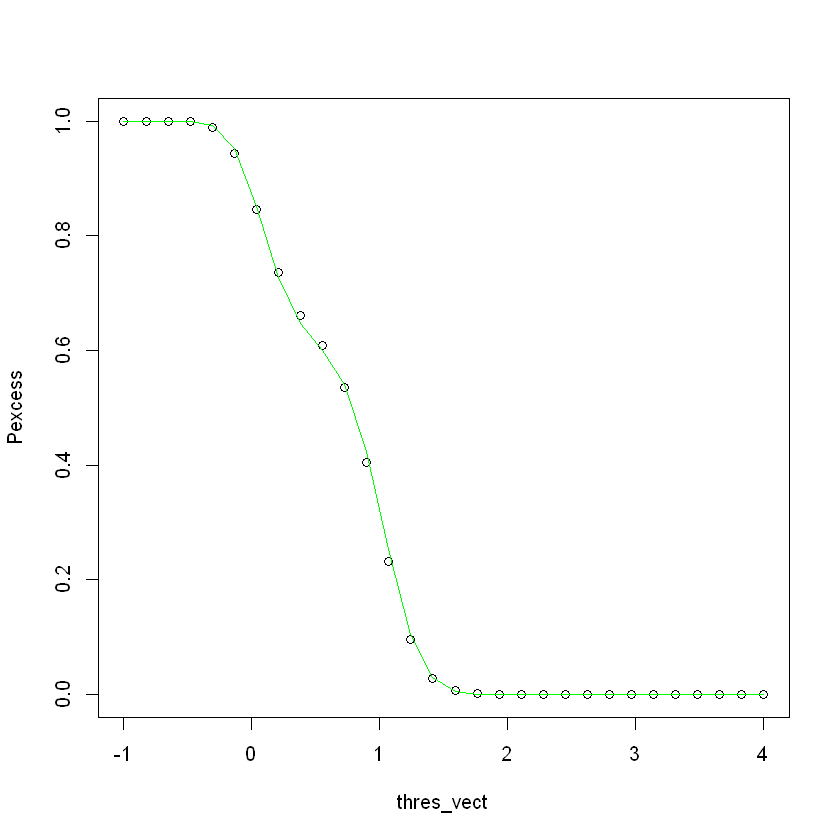

In [114]:
Pexcess <- rep(0,10)
Pexcess_vb <- Pexcess; Pexcess_mh <- Pexcess
thres_vect <-  seq(-1, 4, length.out=30)
for(i in seq_along(thres_vect)){
threshold <- rep(thres_vect[i], 2)
Pexcess[i] <- 1 - gmcdf(x = threshold, Mu = Mu, Sigma=Sigma, p=p)
    
Pexcess_mh[i] <-  ## complete the code:
    ## posterior predictive  estimator using MH output:
    ## use MHpredictiveCdf. 
    1 - MHpredictiveCdf(x = threshold , sample = outputmh , burnin = 1000, thin = 10)
    }

ylim <- range(Pexcess, Pexcess_vb, Pexcess_mh)
plot(thres_vect,Pexcess, ylim = ylim)
lines(thres_vect, Pexcess_mh, col='green')

The line match perfectly the true function.